# I. Preparation

In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms
import matplotlib.pyplot as plt

from nn_interpretability.model.model_trainer import ModelTrainer
from nn_interpretability.model.model_repository import ModelRepository
from nn_interpretability.visualization.mnist_visualizer import MnistVisualizer
from nn_interpretability.visualization.rgb_visualizer import RGBVisualizer
from nn_interpretability.dataset.imagenet_data_loader import ImageNetValDataLoader
from nn_interpretability.dataset.mnist_data_loader import MnistDataLoader
from nn_interpretability.uncertainty.temperature_scaling import TemperatureScaling
from nn_interpretability.visualization.temperature_scaling_visualizer import TemperatureScalingVisualizer
from nn_interpretability.interpretation.deeplift.deeplift import DeepLIFT, DeepLIFTRules

In [2]:
model_name = 'model_cnn.pt'

train = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
mnist_data_loader = MnistDataLoader()

In [4]:
model = ModelRepository.get_general_mnist_cnn(model_name)

if train:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    model.train()
    ModelTrainer.train(model, criterion, optimizer, trainloader)
    
    ModelRepository.save(model, model_name)

In [5]:
def execute_deep_lift(model, data_loader, rule):
    interpreter = DeepLIFT(model, [str(i) for i in range(10)], None, rule)

    images = []

    for i in range(10):
        img = data_loader.get_image_for_class(i)
        out = interpreter.interpret(img)
        out = (out - out.min()) / (out.max() - out.min()) 
        images.append(out.numpy().reshape(28, 28))
    print("RULE: " + rule.name)
    interpreter.cleanup()
    MnistVisualizer.display_images_for_each_class(images)

# II. DeepLIFT Deterministic vs Stochastic Model

Firstly, we are going to examine the impact of stochastic elements in neural networks on the results of `DeepLIFT`. More specifically, we are going to execute `DeepLIFT` for a normal CNN model and for a CNN model containing `Dropout` layers. In the second case, we will differentiate between a single and multiple passes.

## 1. DeepLIFT for a Deterministic Model

Here we are executing for a single picture from every class of MNIST for a standard CNN model.

In [6]:
deterministic_model_name = 'model_cnn.pt'
deterministic_model = ModelRepository.get_general_mnist_cnn(deterministic_model_name)

RULE: LinearRevealCancel


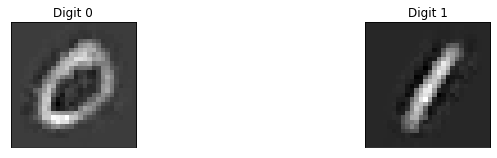

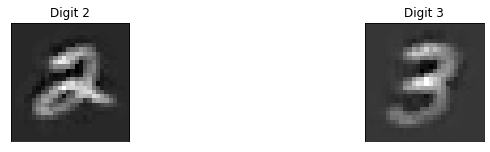

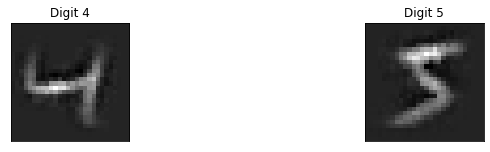

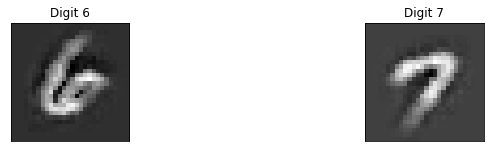

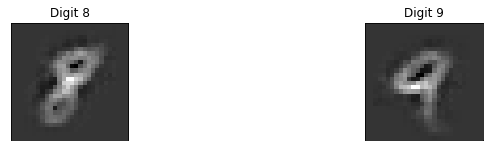

In [7]:
execute_deep_lift(deterministic_model, mnist_data_loader, DeepLIFTRules.LinearRevealCancel)

## 2. DeepLIFT for a Stochastic Model

### 2.1 Single Pass

Now, we switch to the "stochastic" model containing `Dropout` layers. In the first case, we will execute `DeepLIFT` for a member of each class of MNIST in a single pass setting.

In [8]:
stochastic_model_name = 'mc_dropout_cnn.pt'

stochastic_model = ModelRepository.get_cnn_dropout(stochastic_model_name)
stochastic_model.train()
print('Loaded')

Loaded


RULE: LinearRevealCancel


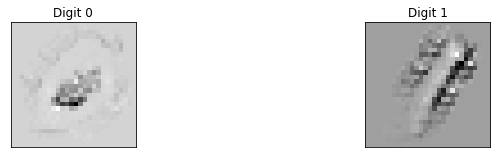

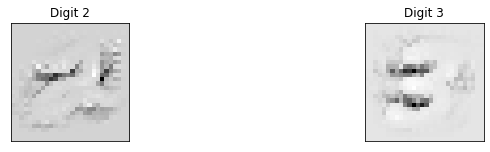

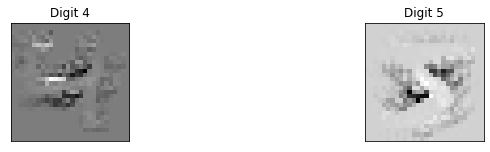

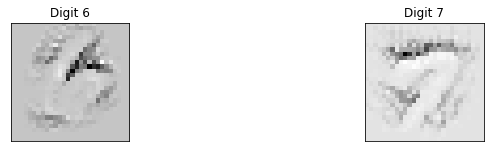

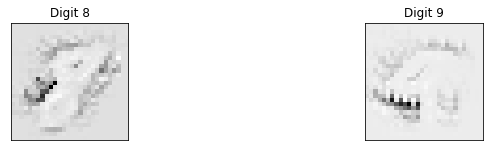

In [9]:
execute_deep_lift(stochastic_model, mnist_data_loader, DeepLIFTRules.LinearRevealCancel)

### 2.2. Multiple passes

In the second case, we are againg executing `DeepLIFT` for a member of each class of MNIST. This time, however, we will do 200 iterations for each image. The results for each image would then be averaged out.

In [10]:
def execute_stochastic_deep_lift(model, data_loader, rule, iterations_per_image):
    """
    Executes DeepLIFT for a single image from each class of MNIST for a stochastic model.
    
    For each image :iterations_per_image iterations are executed.
    """
    interpreter = DeepLIFT(model, [str(i) for i in range(10)], None, rule)

    images = []
    for i in range(10):
        img = data_loader.get_image_for_class(i)
        final = torch.zeros((28, 28))
        
        for i in range(iterations_per_image):
            out = interpreter.interpret(img)
            out = (out - out.min()) / (out.max() - out.min())
            final += out.numpy().reshape(28, 28)
            
        final = final / (torch.ones(1)*iterations_per_image)
        images.append(final)
    print("RULE: " + rule.name)
    interpreter.cleanup()
    MnistVisualizer.display_images_for_each_class(images)

RULE: LinearRevealCancel


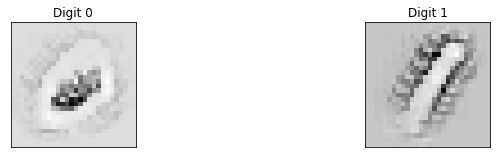

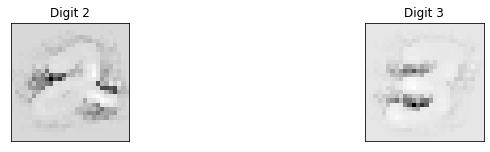

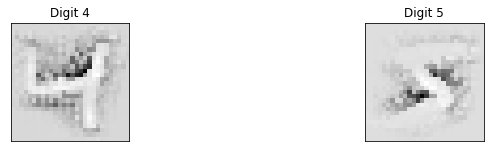

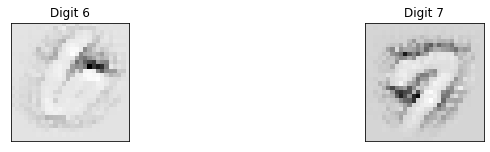

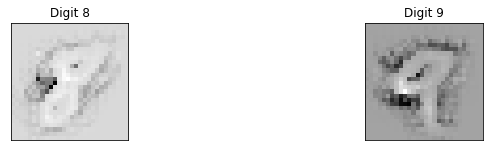

In [11]:
execute_stochastic_deep_lift(stochastic_model, mnist_data_loader, DeepLIFTRules.LinearRevealCancel, 200)

# III. DeepLIFT Random Noise

Now we try to introduce uncertainty to the `DeepLIFT` method and more specifically, the `RevealCancel` rule. In order to do so, we are going to choose an image and execute `DeepLIFT` 1000 times for it. In each iteration, we are adding random noise to the image. If the image was classified for the class C, we are adding the result to the collection of results which are classified for the class C. At the end, we are displaying the composite result for each class. Deep blue image refers to classes for which no classifications have occurred.

In [12]:
def uncertain_deeplift(model, image, T=1000):
    model.train()
    interpretor = DeepLIFT(model, [str(i) for i in range(10)], None, DeepLIFTRules.RevealCancel)
    
    endpoint = torch.zeros_like(image[0]).repeat(10,1,1,1).to(device)
    image = image.to(device)
    times = torch.zeros(10)
    
    for j in range(T):
        noisy_img = img + (torch.randn(img.size()) * 0.5).to(device)
        result = interpretor.interpret(noisy_img).to(device)
        predicted = interpretor.last_prediction()
        
        endpoint[predicted] += result[0]
        times[predicted] += 1
        
    return endpoint.detach().cpu().numpy(), times

In [13]:
deterministic_model_name = 'model_cnn.pt'
deterministic_model = ModelRepository.get_general_mnist_cnn(deterministic_model_name)

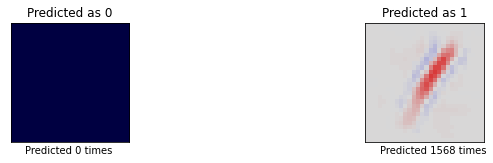

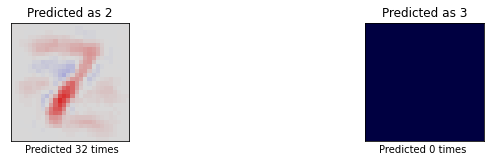

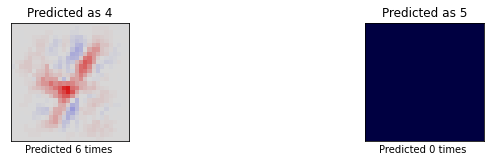

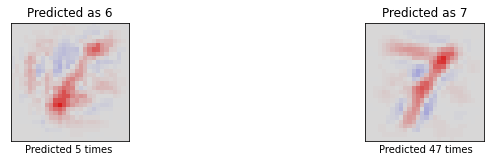

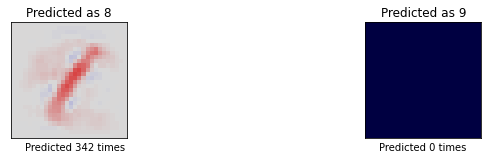

In [14]:
img = mnist_data_loader.get_image_for_class(1)
out, predict_times = uncertain_deeplift(deterministic_model, img, 2000)
MnistVisualizer.dropout_heatmap_for_each_class(out, predict_times)

# IV. Temperature scaling

In this chapter, we are going to examine the technique `Temperature scaling` and it's impact on `DeepLIFT`. To do so, we are first going to consider the MNIST dataset and at a later point, a subset of the ImageNet dataset. 

In [15]:
def generate_conf_acc(model, dataset_loader):
    """
    Computes the confidence estimates and accuracy bins
    needed for the confidence histogram and the reliability
    diagram based on a validation set :dataset_loader for
    a given :model.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    conf_list = [] 
    acc_list = []
    for imgs, label in dataset_loader:
        logits = model(imgs.to(device)).to(device)
        scores = torch.nn.functional.softmax(logits, dim=1)

        conf = torch.max(scores, dim=1).values
        conf_list.append(conf)
        
        acc = scores[torch.arange(label.shape[0]), label]
        acc_list.append(acc)

    return nn.Parameter(torch.cat(conf_list)).to(device), nn.Parameter(torch.cat(acc_list)).to(device)

## 1. MNIST Experiment

In our first experiment, we will execute DeepLIFT for both a standard CNN model and the same CNN model after it has been posprocessed with the technique `Temperature Scaling`.

In [16]:
model_name = 'model_cnn.pt'
model = ModelRepository.get_general_mnist_cnn(model_name)

### 1.1 Base Results for MNIST

The base results for the CNN model before applying `Temperature Scaling` will be generated here.

In [17]:
conf_data, acc_data = generate_conf_acc(model, mnist_data_loader.testloader)

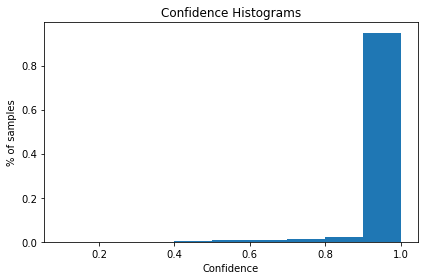

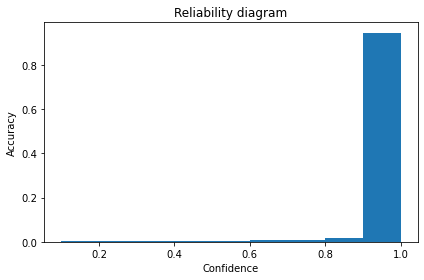

In [18]:
TemperatureScalingVisualizer.confidence_histogram(conf_data.detach().cpu().numpy())
TemperatureScalingVisualizer.reliability_diagram(acc_data.detach().cpu().numpy())

RULE: LinearRevealCancel


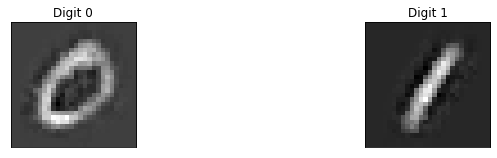

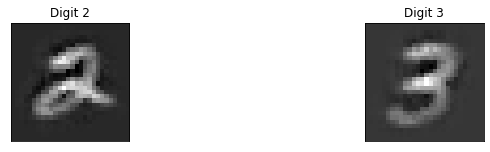

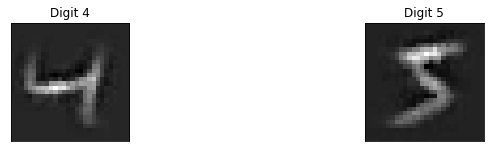

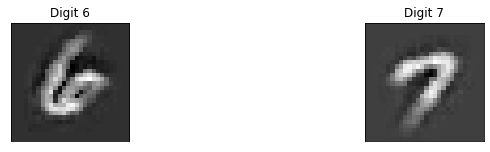

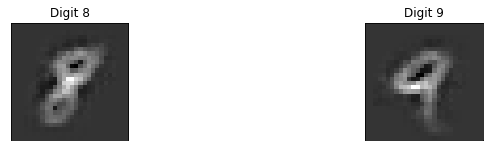

In [19]:
execute_deep_lift(model, mnist_data_loader, DeepLIFTRules.LinearRevealCancel)

### 1.2 Temperature Scaling Results for MNIST

Now we are going apply `Temperature Scaling` to the CNN model to observe the influence it would yield on the results from `DeepLIFT`.

In [20]:
model_t = TemperatureScaling(model, mnist_data_loader.testloader, lr=0.01, iterations=100)

Initial Temperature
1.0
Final Temperature
0.8746548295021057


In [21]:
conf_data, acc_data = generate_conf_acc(model_t, mnist_data_loader.testloader)

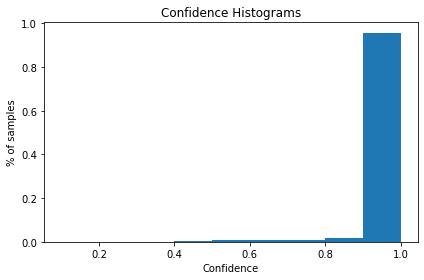

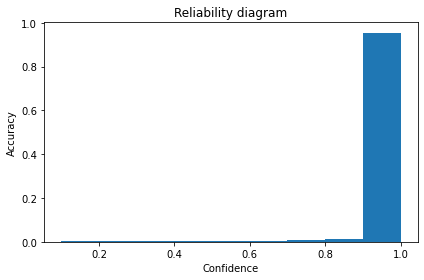

In [22]:
TemperatureScalingVisualizer.confidence_histogram(conf_data.detach().cpu().numpy())
TemperatureScalingVisualizer.reliability_diagram(acc_data.detach().cpu().numpy())

RULE: RevealCancel


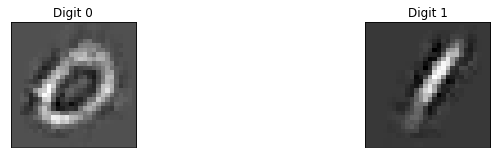

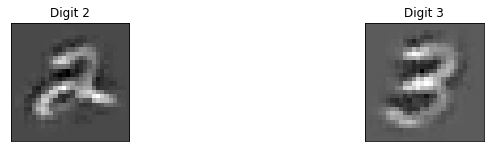

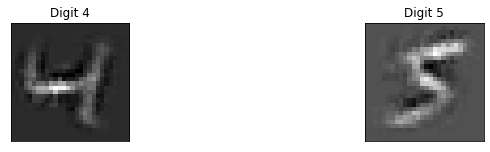

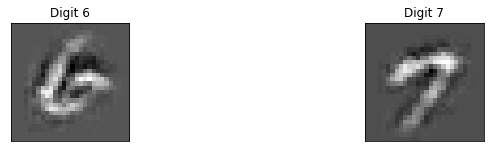

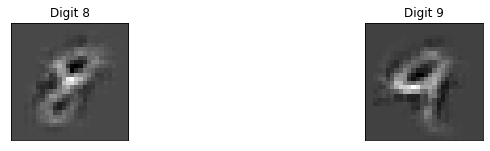

In [23]:
execute_deep_lift(model_t, mnist_data_loader, DeepLIFTRules.RevealCancel)

## 2. ImageNet Experiment

The second experiment we want to do involves a subset of the ImageNet validation set. Furthermore, we have picked the publicly available pretrained `AlexNet` model for our `DeepLIFT` experiment.

In [24]:
alexnet = torchvision.models.alexnet(pretrained=True, progress=True).to(device)

imagenet_data_loader = ImageNetValDataLoader()

img_path = './data/example.JPEG'

C:\Users\Aleksandar\Desktop\projects\bdluam-p4-interpretability-of-nn\implementation\data\ImageNet\val


### 2.1 Base Results

Before we apply `Temperature Scaling`, we will execute `DeepLIFT` for a chosen image in order to produce base results against which we can argue about the impact of `Temperature Scaling`.

In [25]:
conf_data, acc_data = generate_conf_acc(alexnet, imagenet_data_loader.valloader)

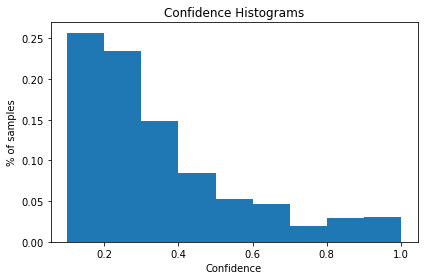

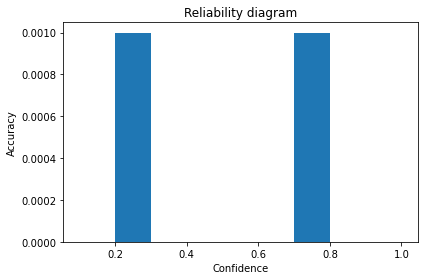

In [26]:
TemperatureScalingVisualizer.confidence_histogram(conf_data.detach().cpu().numpy())
TemperatureScalingVisualizer.reliability_diagram(acc_data.detach().cpu().numpy())

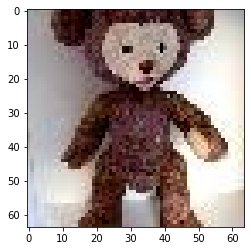

In [27]:
image = RGBVisualizer.read_img(img_path)
image = RGBVisualizer.preprocess(image)

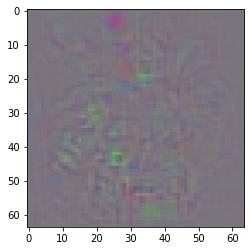

In [28]:
image = RGBVisualizer.read_img(img_path)
image = RGBVisualizer.preprocess(image)

interpreter = DeepLIFT(alexnet, [str(i) for i in range(10)], None, DeepLIFTRules.NoRule)
out = interpreter.interpret(image)
interpreter.cleanup()

out = RGBVisualizer.postprocess(out)
plt.imshow(out)

plt.show()

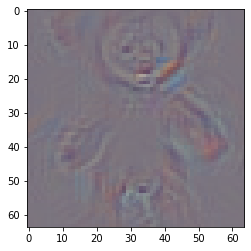

In [29]:
image = RGBVisualizer.read_img(img_path)
image = RGBVisualizer.preprocess(image)

interpreter = DeepLIFT(alexnet, [str(i) for i in range(10)], None, DeepLIFTRules.RevealCancel)
out = interpreter.interpret(image)
interpreter.cleanup()

out = RGBVisualizer.postprocess(out)
plt.imshow(out)

plt.show()

### 2. Temperature Scaling

Now that we have generated base results, we will apply `Temperature Scaling` to the `AlexNet` model and again execute `DeepLIFT` to observe the impact of the technique `Temperature Scaling`.

In [30]:
alexnet_t = TemperatureScaling(alexnet, imagenet_data_loader.valloader,lr=0.01,iterations=100)

Initial Temperature
1.0
Final Temperature
1.7413047552108765


In [31]:
conf_data_t, acc_data_t = generate_conf_acc(alexnet_t, imagenet_data_loader.valloader)

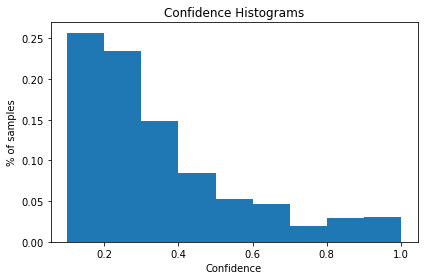

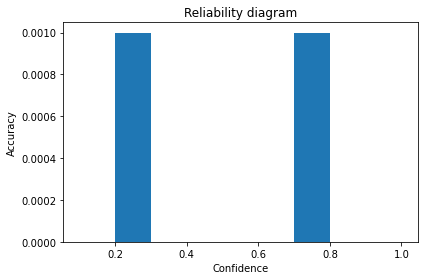

In [32]:
TemperatureScalingVisualizer.confidence_histogram(conf_data.detach().cpu().numpy())
TemperatureScalingVisualizer.reliability_diagram(acc_data.detach().cpu().numpy())

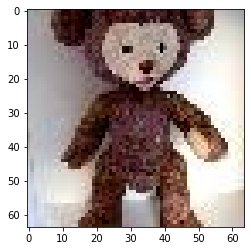

In [33]:
image = RGBVisualizer.read_img(img_path)
image = RGBVisualizer.preprocess(image)

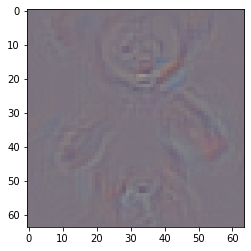

In [34]:
image = RGBVisualizer.read_img(img_path)
image = RGBVisualizer.preprocess(image)

interpreter = DeepLIFT(alexnet_t, [str(i) for i in range(10)], None, DeepLIFTRules.RevealCancel)
out = interpreter.interpret(image)
out = RGBVisualizer.postprocess(out)
interpreter.cleanup()

plt.imshow(out)
plt.show()